In [1]:
import pandas as pd
import re
import numpy as np
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import itertools
import random
from scipy.interpolate import UnivariateSpline
import pickle
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import statsmodels.api as sm
import shap
import polars as pl
from great_tables import GT

/opt/homebrew/Caskroom/miniforge/base/envs/data-science/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Clean Data

## Get tourney seed data

mseed = pd.read_csv("data/MNCAATourneySeeds.csv")
mseed['M_W'] = 'M'
wseed = pd.read_csv("data/WNCAATourneySeeds.csv")
wseed['M_W'] = 'W'
seed = pd.concat([mseed, wseed])
seed['ReigonSeed'] = seed.Seed
seed['Seed'] = [seeds[1:] for seeds in seed.Seed]
seed['play_in_seed'] = list(map(lambda x : x[-1].isalpha(), seed.Seed))
seed['Seed'] = list(map(lambda x : int(re.sub('\D', "", x)), seed.Seed))
tourney_seeds = seed.copy().query("Season>=2010")
all_combo = pd.read_csv('data/SampleSubmissionStage2.csv')['ID']
all_combo = [(int(x[5:9]), int(x[10:])) for x in all_combo]



mslot = pd.read_csv("data/MNCAATourneySlots.csv")
mslot['M_W'] = 'M'
wslot = pd.read_csv("data/WNCAATourneySlots.csv")
wslot['M_W'] = 'W'
slot = pd.concat([mslot, wslot])
conditions = [
    ["R1" in slot for slot in slot.Slot],
    ["R2" in slot for slot in slot.Slot],
    ["R3" in slot for slot in slot.Slot],
    ["R4" in slot for slot in slot.Slot],
    ["R5" in slot for slot in slot.Slot],
    ["R6" in slot for slot in slot.Slot],
]
choices = [1,2,3,4,5,6]
slot["GameRound"] = np.select(conditions, choices, default = 0)
tourney_slots = slot.copy().query("Season>=2010")



m_season_details = pd.read_csv("data/MRegularSeasonDetailedResults.csv")
m_season_details['M_W'] = 'M'
w_season_details = pd.read_csv("data/WRegularSeasonDetailedResults.csv")
w_season_details['M_W'] = 'W'
season_details = pd.concat([m_season_details, w_season_details]).query("Season >= 2010")
winner_season_details = season_details[['M_W', "Season", "DayNum", "WTeamID", "LTeamID", "WScore", "LScore", "WLoc", "WFGM", 
'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', "NumOT"
]].set_axis(['M_W', "Season", "DayNum", "TeamID", "OppTeamID", "Score", "OppScore", "Loc", "FGM", 
'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR',
       'Ast', 'TO', 'Stl', 'Blk', 'PF', "NumOT"], axis=1)
winner_season_details['Result'] = 1
loser_season_details = season_details[['M_W', "Season", "DayNum", "WTeamID", "LTeamID", "WScore", "LScore", 
"WLoc", 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', "NumOT"
]].set_axis(['M_W', "Season", "DayNum", "OppTeamID", "TeamID", "OppScore", "Score", "Loc", "FGM", 
'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR',
       'Ast', 'TO', 'Stl', 'Blk', 'PF', "NumOT"], axis=1)
conditions = [(loser_season_details.Loc == "H").to_list(), 
(loser_season_details.Loc == "A").to_list(), 
(loser_season_details.Loc == "N").to_list()]
choices = ["A", "H", "N"]
loser_season_details['Result'] = 0
loser_season_details["Loc"] = np.select(conditions, choices, default = "ERROR")
season_details = pd.concat([winner_season_details, loser_season_details])
season_details['mov'] = season_details.Score - season_details.OppScore
season_game_results=season_details.copy().query("Season>=2010")

m_tourney_results = pd.read_csv("data/MNCAATourneyCompactResults.csv")
m_tourney_results['M_W'] = 'M'
w_tourney_results = pd.read_csv("data/WNCAATourneyCompactResults.csv")
w_tourney_results['M_W'] = 'W'
tourney_results = pd.concat([m_tourney_results, w_tourney_results]).query("Season >= 2010")

mteams = pd.read_csv("data/MTeams.csv")
mteams['M_W'] = 'M'
wteams = pd.read_csv("data/WTeams.csv")
wteams['M_W'] = 'W'
teams = pd.concat([mteams, wteams])

# Get mixed effects for each team for each season
all_effects = []
for season in range(2010, max(season_game_results.Season)+1):
    print(season)
    print("--------")
    for m_w in ["M", "W"]:
        print(m_w)
        # Build own rankings with mixed effects model
        mod_df = season_game_results.query("Season == @season & M_W == @m_w & NumOT == 0")[["TeamID", "OppTeamID", "Result"]].copy()
        if len(mod_df) == 0:
            continue
        mod_df['TeamID']=mod_df['TeamID'].astype("str")
        mod_df['OppTeamID']=mod_df['OppTeamID'].astype("str")
        formula = 'Result~-1+TeamID+OppTeamID'
        glm = sm.GLM.from_formula(formula=formula, 
                                data=mod_df, 
                                family=sm.families.Binomial()).fit()
        
        quality = pd.DataFrame(glm.params).reset_index()
        quality.columns = ['TeamID','Effect']
        quality['Season'] = season
        quality = quality.loc[~(quality.TeamID.str.contains('Opp'))].reset_index(drop=True)
        quality['TeamID'] = quality['TeamID'].apply(lambda x: x[7:11]).astype(int)
        quality["M_W"] = m_w

        all_effects.append(quality)
all_effects = pd.concat(all_effects, axis = 0)
all_effects["TeamID"] = all_effects["TeamID"].astype(int)

all_matchup = pl.read_csv('data/SampleSubmissionStage2.csv').with_columns(
    team_1 = pl.col("ID").str.slice(5, length=4).cast(pl.Int64), 
    team_2 = pl.col("ID").str.slice(10, length=4).cast(pl.Int64)).drop("Pred").join(
        teams.pipe(pl.from_pandas).select("TeamID", "M_W").rename({"TeamID" : "team_1"}),
        on = "team_1",
        how = "left")
    
all_matchup_m = [(row['team_1'], row['team_2']) for row in all_matchup.filter(pl.col("M_W")=="M").iter_rows(named = True)]
all_matchup_w = [(row['team_1'], row['team_2']) for row in all_matchup.filter(pl.col("M_W")=="W").iter_rows(named = True)]

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/var/folders/xs/5ps3sp7d651c8whk_0_xk6580000gn/T/ipykernel_77332/3785498367.py:13: SyntaxWarning: invalid escape sequence '\D'
  seed['Seed'] = list(map(lambda x : int(re.sub('\D', "", x)), seed.Seed))


2010
--------
M
W
2011
--------
M
W
2012
--------
M
W
2013
--------
M
W
2014
--------
M
W
2015
--------
M
W
2016
--------
M
W
2017
--------
M
W
2018
--------
M
W
2019
--------
M
W
2020
--------
M
W
2021
--------
M
W
2022
--------
M
W
2023
--------
M
W
2024
--------
M
W
2025
--------
M
W


In [3]:
# Check 2025 Random Effect Scores

all_effects.merge(mteams[["TeamID", "TeamName", "M_W"]], on = ["TeamID", "M_W"], how = "left").sort_values("Effect", ascending = False).query("M_W == 'M'").query("Season == 2025")

,TeamID,Effect,Season,M_W,TeamName
10628,1222,7.511408,2025,M,Houston
10532,1120,7.074281,2025,M,Auburn
10604,1196,6.803291,2025,M,Florida
10589,1181,6.257020,2025,M,Duke
10798,1397,6.233868,2025,M,Tennessee
...,...,...,...,...,...
10677,1271,-3.498278,2025,M,MD E Shore
10562,1154,-3.801890,2025,M,Citadel
10744,1341,-4.095967,2025,M,Prairie View
10528,1115,-4.202008,2025,M,Ark Pine Bluff


In [4]:
# Define all objects

all_years = season_game_results.Season.unique()
possible_num_games_back = [15]
possible_exponential_decays = [0.9]

cache = dict({year: 
              dict({
                  n_games : dict({
                      exp_dec : dict() 
                      for exp_dec in possible_exponential_decays}) 
                      for n_games in possible_num_games_back}) 
                      for year in all_years})
#with open("cache.pickle", "rb") as handle:
 #   cache = pickle.load(handle)

class OurMod:
    def __init__(self, train_x, train_y, with_glm = False): 
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        self.param = {} 
        self.param['eval_metric'] =  'mae'
        self.param['booster'] = 'gbtree'
        self.param['eta'] = 0.05 #change to ~0.02 for final run
        self.param['subsample'] = 0.35
        self.param['colsample_bytree'] = 0.7
        self.param['num_parallel_tree'] = 3 #recommend 10
        self.param['min_child_weight'] = 40
        self.param['gamma'] = 10
        self.param['max_depth'] =  3
        self.xgb = np.nan
        self.train_x = train_x
        self.train_y = train_y
        self.spline = np.nan
        self.with_glm = with_glm

    def fit(self):
        # Hyperparamter Tune (With repeated folds)
        xgb_cv = []
        repeat_cv = 3 # recommend 10
        dtrain = xgb.DMatrix(self.train_x.values, label = self.train_y) 
        for i in range(repeat_cv): 
            # print(f"Fold repeater {i}")
            xgb_cv.append(
                xgb.cv(
                    params = self.param,
                    dtrain = dtrain,
                    obj = cauchyobj,
                    num_boost_round = 3000,
                    folds = KFold(n_splits = 5, shuffle = True, random_state = i),
                    early_stopping_rounds = 25,
                    verbose_eval=False
                )
            )
        iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
        val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
        # print(f"iteration_counts : {iteration_counts}, val_mae : {val_mae}")

        # Train model with ideal parameters (for each repeated cv from above)
        oof_preds = []
        self.xgb = []
        xgb_indexer=0
        for i in range(repeat_cv):
            # print(f"Fold repeater {i}")
            preds = self.train_y.copy()
            kfold = KFold(n_splits = 5, shuffle = True, random_state = i)  
            for train_index, val_index in kfold.split(self.train_x.values,self.train_y):
                dtrain_i = xgb.DMatrix(self.train_x.values[train_index], label = self.train_y[train_index])
                dval_i = xgb.DMatrix(self.train_x.values[val_index], label = self.train_y[val_index])  
                self.xgb.append(xgb.train(
                    params = self.param,
                    dtrain = dtrain_i,
                    num_boost_round = iteration_counts[i],
                    verbose_eval = False
                ))
                preds[val_index] = self.xgb[xgb_indexer].predict(dval_i)
                xgb_indexer+=1
            oof_preds.append(np.clip(preds,-30,30))
        plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(self.train_y>0,1,0)})
        plot_df["pred_int"] = plot_df["pred"].astype(int)
        plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')
        
        # Train multiple splines with cross validation (will average results)
        self.spline = []
        for i in range(repeat_cv):
            dat = list(zip(oof_preds[i],np.where(self.train_y>0,1,0)))
            dat = sorted(dat, key = lambda x: x[0])
            datdict = {}
            for k in range(len(dat)):
                datdict[dat[k][0]]= dat[k][1]
            self.spline.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
            spline_fit = self.spline[i](oof_preds[i])
            print(f"logloss of cvsplit {i}: {log_loss(np.where(self.train_y>0,1,0),spline_fit)}")

    def predict(self, x):
        x = xgb.DMatrix(x)
        pred_mov = []
        for i in range(len(self.xgb)):
            pred_mov.append(np.array(self.xgb[i].predict(x)))
        pred_mov = np.column_stack(pred_mov)
        return np.mean(pred_mov, axis = 1)
    
    def predict_proba(self, x):
        predict_mov = self.predict(x)
        all_pred_prob = []
        for i in range(len(self.spline)):
            predicted_probabilities = self.spline[i](predict_mov)
            predicted_probabilities = [x if x < 0.975 else 0.975 for x in predicted_probabilities]
            predicted_probabilities = [x if x > 0.025 else 0.025 for x in predicted_probabilities]
            all_pred_prob.append(np.array(predicted_probabilities))
        all_pred_prob = np.column_stack(all_pred_prob)
        return np.mean(all_pred_prob, axis = 1)

class team:
    def __init__(self, team_id: int, year: int, cache=cache) -> None:
        self.team_id = team_id
        self.year = year
        self.team_game_results = season_game_results.query(
            "TeamID == @team_id & Season == @year"
        )
        self.opp_game_results = season_game_results.query(
            "OppTeamID == @team_id & Season == @year"
        )
        self.cache = cache

    def get_past_n_record(self, n: int, exponential_downweight : float) -> float:
        """Get (percentage) record over past 10 games"""
        past_n_record = self.team_game_results.sort_values("DayNum", ascending=False).head(n).Result
        weights = np.array([exponential_downweight**i for i in range(len(past_n_record))])
        past_n_record = np.array(past_n_record*weights).sum() / weights.sum()

        return past_n_record

    def get_strength_of_schedule(self, n, exponential_downweight : float) -> float:
        """Get average overall kempom of past n game matchups"""
        last_n_opponents = self.team_game_results.sort_values(
            "DayNum", ascending=False
        ).OppTeamID.head(n)
        opp_ranks = all_effects.query("Season==@self.year & TeamID in @last_n_opponents").reset_index(drop = 1).Effect
        weights = np.array([exponential_downweight**i for i in range(len(opp_ranks))])
        return np.array(opp_ranks*weights).sum() / weights.sum()

    def get_road_record(self) -> float:
        """Get overall road record"""
        road_record = self.team_game_results.query("Loc == 'A'").Result.mean()
        return road_record

    def get_tourney_seed(self):
        """Get tourney seed"""
        try:
            return (
                tourney_seeds.query(f"Season == @self.year & TeamID == @self.team_id")
                .reset_index(drop=1)
                .Seed[0]
            )
        except KeyError:
            return 17  # If either (1) tourney seeds not released or (2) team did not make tourney assign fictional seed "17"

    def get_on_court_features(self, n_games_back, exponential_downweight):
        num_prev = len(self.team_game_results)
        weights = np.array([exponential_downweight**i for i in range(n_games_back)])[:num_prev]
        desired_vars = ["FGM",
                            "FGA",
                            "FGM3",
                            "FGA3",
                            "FTM",
                            "FTA",
                            "OR",
                            "DR",
                            "Ast",
                            "TO",
                            "Stl",
                            "Blk",
                            "mov"
                        ]
        court_features_mean = pd.DataFrame(
            {
                items[0]: [items[1]]
                for items in dict(
                    self.team_game_results.
                    sort_values("DayNum", ascending=False)
                    .head(n_games_back)[desired_vars]
                    .add_suffix(f"_mean")
                    .mul(weights, axis=0)
                    .mean()
                ).items()
            }
        )

        opp_court_features_mean = pd.DataFrame(
            {
                items[0]: [items[1]]
                for items in dict(
                    self.opp_game_results.
                    sort_values("DayNum", ascending=False)
                    .head(n_games_back)[desired_vars]
                    .add_suffix(f"_opp_mean")
                    .mul(weights, axis=0)
                    .mean()
                ).items()
            }
        )

        court_features_min = pd.DataFrame(
            {
                items[0]: [items[1]]
                for items in dict(
                    self.team_game_results.
                    sort_values("DayNum", ascending=False)
                    .head(n_games_back)[desired_vars]
                    .add_suffix(f"_min")
                    .mul(weights, axis=0)
                    .min()
                ).items()
            }
        )

        opp_court_features_min = pd.DataFrame(
            {
                items[0]: [items[1]]
                for items in dict(
                    self.opp_game_results.
                    sort_values("DayNum", ascending=False)
                    .head(n_games_back)[desired_vars]
                    .add_suffix(f"_opp_min")
                    .mul(weights, axis=0)
                    .min()
                ).items()
            }
        )

        court_features_max = pd.DataFrame(
            {
                items[0]: [items[1]]
                for items in dict(
                    self.team_game_results.
                    sort_values("DayNum", ascending=False)
                    .head(n_games_back)[desired_vars]
                    .add_suffix(f"_max")
                    .mul(weights, axis=0)
                    .max()
                ).items()
            }
        )

        opp_court_features_max = pd.DataFrame(
            {
                items[0]: [items[1]]
                for items in dict(
                    self.opp_game_results.
                    sort_values("DayNum", ascending=False)
                    .head(n_games_back)[desired_vars]
                    .add_suffix(f"_opp_max")
                    .mul(weights, axis=0)
                    .max()
                ).items()
            }
        )

        court_features = pd.concat([court_features_mean, court_features_min, opp_court_features_min,
                                    opp_court_features_mean, court_features_max, opp_court_features_max], axis=1)
        return court_features
    
    def get_mixed_effect_ranking(self):
        """Get rankings via mixed effects model from season games"""
        try:
            effect = all_effects.query("Season==@self.year & TeamID == @self.team_id").Effect.reset_index(drop = 1)[0]
        except KeyError:
            effect = np.nan # If team not shown in data
        return effect
    
    def get_historical_mixed_effect_ranking(self, exponential_downweight):
        """Get rankings via mixed effects model from season games"""
        try:
            effect = all_effects.query("Season>=@self.year-3 & TeamID == @self.team_id").Effect.values
            weights = np.array([exponential_downweight**i for i in range(len(effect))])
            effect = np.mean(effect*weights)
        except KeyError:
            effect = np.nan # If team not shown in data
        return effect


    def collect_features(self, n_games: int, exponential_downweight):
        """Collect current team level modeling features"""
        if self.team_id in self.cache.get(self.year).get(n_games)[exponential_downweight].keys():
            self.cache.get(self.year)[n_games][exponential_downweight][self.team_id]
        features = pd.DataFrame(
            dict(
                {
                    "pasn_n_road_record" : [self.get_past_n_record(n=n_games, exponential_downweight=exponential_downweight)],
                    "past_n_record": [self.get_past_n_record(n=n_games, exponential_downweight=exponential_downweight)],
                    "get_tourney_rank": [self.get_tourney_seed()],
                    "get_team_effect":[self.get_mixed_effect_ranking()],
                    "historical_team_effect":[self.get_historical_mixed_effect_ranking(exponential_downweight=exponential_downweight)],
                    "get_sos" : [self.get_strength_of_schedule(n=n_games, exponential_downweight=exponential_downweight)]
                }
            )
        )
        on_court_features = self.get_on_court_features(n_games_back = n_games, exponential_downweight=exponential_downweight)
        features = pd.concat([features, on_court_features], axis=1)
        self.cache.get(self.year)[n_games][exponential_downweight][self.team_id] = features
        return features


class playoff_matchup:
    def __init__(
        self, team_id_1: int, team_id_2: int, n_games: int, exponential_downweight : float, cache=cache
    ) -> None:
        """Init playoff_matchup class."""
        team_ids = [team_id_1, team_id_2]
        self.team_id_1 = min(team_ids)  # Ensures lower team_id is the one predicted for
        self.team_id_2 = max(team_ids)
        self.n_games = n_games
        self.exponential_downweight = exponential_downweight
        self.cache = cache

    def collect_features(self, year: int):
        """Collect features for playoff modeling"""
        if not (self.team_id_1 in self.cache.get(year)[self.n_games][self.exponential_downweight].keys()):
            team_1_class = team(team_id=self.team_id_1, year=year)
            team_1_features = team_1_class.collect_features(
                n_games=self.n_games,
                exponential_downweight=self.exponential_downweight
            )
        if not (self.team_id_2 in self.cache.get(year)[self.n_games][self.exponential_downweight].keys()):
            team_2_class = team(team_id=self.team_id_2, year=year)
            team_2_features = team_2_class.collect_features(
                n_games=self.n_games,
                exponential_downweight=self.exponential_downweight
            )
        team_1_features = pd.DataFrame(
            self.cache.get(year)[self.n_games][self.exponential_downweight].get(self.team_id_1)
        ).add_suffix(f"_T1")
        team_2_features = pd.DataFrame(
            self.cache.get(year)[self.n_games][self.exponential_downweight].get(self.team_id_2)
        ).add_suffix(f"_T2")
        features = pd.concat([team_1_features, team_2_features], axis=1)
        features["seed_diff"] = features["get_tourney_rank_T1"] - features["get_tourney_rank_T2"]
        features["effect_diff"] = features["get_team_effect_T1"] - features["get_team_effect_T2"]
        return features

    def predict(self, year, model):
        """Predicts probability of smaller team_id winning"""
        game_features = self.collect_features(year=year)
        predictions = model.predict(game_features)
        prob_lower_team_id = predictions[1]
        return prob_lower_team_id


class trainer:
    def __init__(self, n_games: int, exponential_downweight : float, with_glm = False):
        """Init class trainer."""
        self.features_men = np.nan
        self.labels_men = np.nan
        self.model_men = np.nan
        self.season_key_men = np.nan
        self.with_glm = with_glm
        self.exponential_downweight=exponential_downweight

        self.features_women = np.nan
        self.labels_women = np.nan
        self.model_women = np.nan
        self.season_key_women = np.nan

        self.all_years = tourney_results.Season.unique()
        self.n_games = n_games

    def get_features_labels(self, gender: str):
        """Gets features and labels for all years for a certain gender."""
        all_features_list = []
        all_labels = np.array([])
        season_keys = np.array([])

        for year in tqdm(self.all_years):
            tourney_results_year = tourney_results.query(
                "Season == @year & M_W == @gender"
            )
            for index, row in enumerate(tourney_results_year.itertuples()):
                team_ids = [row.WTeamID, row.LTeamID]
                team_id_1 = min(team_ids)
                if row.WTeamID == team_id_1:
                    label = row.WScore - row.LScore
                else:
                    label = row.LScore - row.WScore
                all_labels = np.append(all_labels, label)
                matchup_class = playoff_matchup(
                    min(team_ids),
                    max(team_ids),
                    n_games=self.n_games,
                    exponential_downweight=self.exponential_downweight
                )
                this_game_features = matchup_class.collect_features(year=row.Season)
                all_features_list.append(this_game_features.copy())
                season_keys = np.append(season_keys, year)
        all_features = pd.concat(all_features_list)
        return dict(
            {
                "all_features": all_features,
                "all_labels": all_labels,
                "season_keys": season_keys,
            }
        )

    def label_and_data_maker(self):
        """Create training and label sets for all NCAA matchups (men and women)"""
        print("Getting Mens Training Data:")
        men = self.get_features_labels(gender="M")
        print("Getting Womens Training Data:")
        women = self.get_features_labels(gender="W")

        self.features_men = men["all_features"]
        self.labels_men = men["all_labels"]
        self.season_key_men = men["season_keys"]
        self.features_women = women["all_features"]
        self.labels_women = women["all_labels"]
        self.season_key_women = women["season_keys"]

    def train(self, verbose = True):
        """Trains Models for both MNCAA and WNCAA"""
        max_year = int(self.season_key_men.max()) + 1
        all_mses = []

        # Hyperparameter tune
        for year in range(2021, max_year):
            if year == 2020:
                continue
            X_train_men, X_test_men, y_train_men, y_test_men = (
                self.features_men[self.season_key_men < year],
                self.features_men[self.season_key_men == year],
                self.labels_men[self.season_key_men < year],
                self.labels_men[self.season_key_men == year],
            )
            self.model_men = OurMod(X_train_men, y_train_men, with_glm=self.with_glm)
            print("Training Mens Model")
            self.model_men.fit()

            X_train_women, X_test_women, y_train_women, y_test_women = (
                self.features_women[self.season_key_women < year],
                self.features_women[self.season_key_women == year],
                self.labels_women[self.season_key_women < year],
                self.labels_women[self.season_key_women == year],
            )
            model_women = OurMod(X_train_women, y_train_women, with_glm=self.with_glm)
            print("Training Womens Model")
            model_women.fit()

            pred_men_prob = self.model_men.predict_proba(X_test_men).tolist()
            pred_women_prob = model_women.predict_proba(X_test_women).tolist()
            pred_men_binary = [x > 0.5 for x in pred_men_prob]  # prob greater than 0.5
            pred_women_binary = [x > 0.5 for x in pred_women_prob]
            y_test_men_binary = [x > 0 for x in y_test_men]  # mov greater than 0
            y_test_women_binary = [x > 0 for x in y_test_women]
            pred_overall_prob, y_test_overall_binary = pred_men_prob.copy(), y_test_men_binary.copy()
            pred_overall_prob.extend(pred_women_prob)
            y_test_overall_binary.extend(y_test_women_binary)

            # log_loss(np.where(self.train_y>0,1,0),spline_fit)
            
            
            accuracy_men = accuracy_score(y_test_men_binary, pred_men_binary)
            mse_men = mean_squared_error(y_test_men_binary, pred_men_prob)
            log_loss_men = log_loss(y_test_men_binary, pred_men_prob)
            accuracy_women = accuracy_score(y_test_women_binary, pred_women_binary)
            mse_women = mean_squared_error(y_test_women_binary, pred_women_prob)
            log_loss_women = log_loss(y_test_women_binary, pred_women_prob)
            mse_overall = mean_squared_error(y_test_overall_binary, pred_overall_prob)
            all_mses.append(mse_overall)
            if verbose:
                print(
                    f"Mens accuracy for {year} is {round(accuracy_men * 100, 2)} percent. MSE is {round(mse_men, 6)}. Log loss is {round(log_loss_men, 6)}"
                )
                print(
                    f"Womens accuracy for {year} is {round(accuracy_women * 100, 2)} percent. MSE is {round(mse_women, 6)}. Log loss is {round(log_loss_women, 6)}"
                )
                print(
                    f"Overall MSE for {year} is {round(mse_overall, 6)}"
                )
        X_train_men, y_train_men = (
            self.features_men[self.season_key_men < max_year],
            self.labels_men[self.season_key_men < max_year],
        )
        self.model_men = OurMod(X_train_men, y_train_men, with_glm=self.with_glm)
        self.model_men.fit()

        X_train_women, y_train_women = (
            self.features_women[self.season_key_women < max_year],
            self.labels_women[self.season_key_women < max_year],
        )
        self.model_women = OurMod(X_train_women, y_train_women, with_glm=self.with_glm)
        self.model_women.fit()
        return all_mses


class tournament:
    def __init__(self, year, mens_model, womens_model, n_games, exponential_downweight):
        self.year = year
        self.n_games = n_games
        self.this_year_tourney_teams_mens = tourney_seeds.query(
            "Season == @year & M_W == 'M'"
        ).TeamID
        self.this_year_tourney_teams_womens = tourney_seeds.query(
            "Season == @year & M_W == 'W'"
        ).TeamID
        self.mens_model = mens_model
        self.womens_model = womens_model
        self.mens_features = np.nan
        self.womens_features = np.nan
        self.predictions = np.nan
        self.exponential_downweight = exponential_downweight

    def predict_all_including_non_possible(self):
        """Predicts probabilities for every pair of matchups for all teams"""
        # get all possible matchups
        all_womens_matchups = all_matchup_w.copy()
        all_mens_matchups = all_matchup_m.copy()

        womens_features = pd.DataFrame()
        womens_matchup_strings = []
        mens_features = pd.DataFrame()
        mens_matchup_strings = []
        for matchup in tqdm(all_mens_matchups):
            matchup_list = [matchup[0], matchup[1]]
            matchup_class = playoff_matchup(
                team_id_1=matchup[0],
                team_id_2=matchup[1],
                n_games=self.n_games,
                exponential_downweight=self.exponential_downweight
                )
            matchup_features = matchup_class.collect_features(year=self.year)
            mens_features = pd.concat([mens_features.copy(), matchup_features.copy()])
            matchup_string = f"{self.year}_{min(matchup_list)}_{max(matchup_list)}"
            mens_matchup_strings.append(matchup_string)
        for matchup in tqdm(all_womens_matchups):
            matchup_list = [matchup[0], matchup[1]]
            matchup_class = playoff_matchup(
                team_id_1=matchup[0],
                team_id_2=matchup[1],
                n_games=self.n_games,
                exponential_downweight=self.exponential_downweight
                )
            matchup_features = matchup_class.collect_features(year=self.year)
            womens_features = pd.concat(
                [womens_features.copy(), matchup_features.copy()]
            )
            matchup_string = f"{self.year}_{min(matchup_list)}_{max(matchup_list)}"
            womens_matchup_strings.append(matchup_string)


        mens_predictions = self.mens_model.predict_proba(mens_features)
        womens_predictions = self.womens_model.predict_proba(womens_features)
        self.predictions = pd.DataFrame(
            {
                "ID": np.append(mens_matchup_strings, womens_matchup_strings),
                "Pred": np.append(mens_predictions, womens_predictions),
            }
        )
        return self.predictions

    def predict_exact_tourney(self, gender: str, print_results=True):
        """Predicts binary outputs for each progressive round of tourney"""
        # if not run simulate all do that
        if not isinstance(self.predictions, pd.DataFrame):
            print("Predictions need to be run for this tourney, running now...")
            predictions = self.predict_all_including_non_possible()
        tourney_seeds_this_year = tourney_seeds.query(
            "Season == @self.year & M_W == @gender"
        )
        tourney_slots_this_year = tourney_slots.query(
            "Season == @self.year & M_W == @gender"
        )
        updating_seed_record = dict(
            {
                tourney_seeds_this_year.query("TeamID == @team_id")
                .reset_index(drop=1)
                .ReigonSeed[0]: team_id
                for team_id in tourney_seeds_this_year.TeamID
            }
        )
        for game_round in np.sort(tourney_slots.GameRound.unique()):
            slots_this_round = tourney_slots_this_year.query("GameRound == @game_round")
            if print_results:
                print(f"Simulating Round {game_round}...")
            for index, row in enumerate(slots_this_round.itertuples()):
                teams_in_matchup = [
                    updating_seed_record.get(row.StrongSeed),
                    updating_seed_record.get(row.WeakSeed),
                ]
                team_1 = min(teams_in_matchup)
                team_2 = max(teams_in_matchup)
                id_in_probs = f"{self.year}_{team_1}_{team_2}"
                prediction = (
                    self.predictions.query("ID == @id_in_probs")
                    .reset_index(drop=1)
                    .Pred[0]
                )
                if random.random() <= prediction:
                    updating_seed_record[row.Slot] = team_1
                    team_name_win = (
                        teams.query("TeamID == @team_1").reset_index(drop=1).TeamName[0]
                    )
                    team_name_lost = (
                        teams.query("TeamID == @team_2").reset_index(drop=1).TeamName[0]
                    )
                    if teams_in_matchup[0] == team_1:
                        win_seed = row.StrongSeed
                        lose_seed = row.WeakSeed
                    else:
                        win_seed = row.WeakSeed
                        lose_seed = row.StrongSeed
                    win_prob = prediction
                else:
                    updating_seed_record[row.Slot] = team_2
                    team_name_win = (
                        teams.query("TeamID == @team_2").reset_index(drop=1).TeamName[0]
                    )
                    team_name_lost = (
                        teams.query("TeamID == @team_1").reset_index(drop=1).TeamName[0]
                    )
                    if teams_in_matchup[0] == team_1:
                        lose_seed = row.StrongSeed
                        win_seed = row.WeakSeed
                    else:
                        lose_seed = row.WeakSeed
                        win_seed = row.StrongSeed
                    win_prob = 1 - prediction
                if print_results:
                    print(
                        f"Seed {win_seed}. {team_name_win} beats seed {lose_seed} {team_name_lost} (with probability {win_prob})"
                    )
        return updating_seed_record

    def get_all_possible_in_slot(self, slot, gender):
        """Recursively retrieve all possible teams that could occupy a bracket slot."""
        all_slots = tourney_slots.query("Season == @self.year & M_W == @gender")
        tourney_seeds_this_year = tourney_seeds.query("Season == 2023 & M_W == 'M'")
        try:
            slot_documentation = (
                all_slots.query("Slot == @slot").reset_index(drop=1).iloc[0]
            )
        except IndexError:
            return slot
        strong_slot_seed = slot_documentation.StrongSeed
        weak_slot_seed = slot_documentation.WeakSeed
        all_possible_strong_side = self.get_all_possible_in_slot(
            strong_slot_seed, gender
        )
        all_possible_weak_side = self.get_all_possible_in_slot(weak_slot_seed, gender)
        return np.append(all_possible_strong_side, all_possible_weak_side)

    def get_one_round_back_ansestors(self, slot, gender):
        all_slots = tourney_slots.query("Season == @self.year & M_W == @gender")
        slot_documentation = (
            all_slots.query("Slot == @slot").reset_index(drop=1).iloc[0]
        )
        return np.array([slot_documentation.StrongSeed, slot_documentation.WeakSeed])

    def get_team_round_probabilities(self, gender):
        slots_this_year = tourney_slots.query("Season == @self.year & M_W == @gender")
        seeds_this_year = tourney_seeds.query("Season == @self.year & M_W == @gender")
        teams_this_year = seeds_this_year.TeamID.unique()
        team_chances = pd.DataFrame(
            {
                "TeamID": teams_this_year,
                "TeamName": [
                    teams.query("TeamID == @team_id").reset_index(0).iloc[0].TeamName
                    for team_id in teams_this_year
                ],
            }
        )
        for this_round in [0, 1, 2, 3, 4, 5, 6]:
            slots_this_round = slots_this_year.query("GameRound == @this_round").Slot
            team_round_probs = dict(
                {team_id: np.array([]) for team_id in teams_this_year}
            )
            teams_accounted_for = []
            for slot in slots_this_round:
                ansestor_slot_1, ansestor_slot_2 = self.get_one_round_back_ansestors(
                    slot, gender
                )
                possible_seeds_ansestor_1 = self.get_all_possible_in_slot(
                    slot=ansestor_slot_1, gender=gender
                )
                possible_seeds_ansestor_2 = self.get_all_possible_in_slot(
                    slot=ansestor_slot_2, gender=gender
                )
                possible_team_ids_ansestor_1 = seeds_this_year.query(
                    "ReigonSeed in @possible_seeds_ansestor_1"
                ).TeamID.tolist()
                possible_team_ids_ansestor_2 = seeds_this_year.query(
                    "ReigonSeed in @possible_seeds_ansestor_2"
                ).TeamID.tolist()
                possible_team_ids_all = np.append(
                    possible_team_ids_ansestor_1, possible_team_ids_ansestor_2
                )
                teams_accounted_for.extend(possible_team_ids_all)
                possible_slot_matchups = list(
                    itertools.product(
                        possible_team_ids_ansestor_1, possible_team_ids_ansestor_2
                    )
                )
                possible_game_ids = [
                    f"{self.year}_{min(matchup_teams)}_{max(matchup_teams)}"
                    for matchup_teams in possible_slot_matchups
                ]
                for game_id in possible_game_ids:
                    team_1 = int(game_id[5:9])
                    team_2 = int(game_id[10:14])
                    prob_t1_wins_given_t2 = (
                        self.predictions.query("ID == @game_id")
                        .reset_index(drop=1)
                        .Pred[0]
                    )  # P(T1 Wins | T2 Opponent)
                    prob_t2_wins_given_t1 = 1 - prob_t1_wins_given_t2
                    if this_round == 0:
                        prob_t1_makes_it_here = 1
                        prob_t2_makes_it_here = 1
                    else:
                        prob_t1_makes_it_here = (
                            team_chances.query("TeamID == @team_1")
                            .reset_index(drop=1)
                            .iloc[0][f"Round_{this_round - 1}"]
                        )  # P(T1 Opponent)
                        prob_t2_makes_it_here = (
                            team_chances.query("TeamID == @team_2")
                            .reset_index(drop=1)
                            .iloc[0][f"Round_{this_round - 1}"]
                        )
                    prob_t1_wins_and_t2_opp = (
                        prob_t1_wins_given_t2
                        * prob_t1_makes_it_here
                        * prob_t2_makes_it_here
                    )  # P(T1 wins and T2 Opponent) = P(T1 Wins | T1 makes, T2 makes) * P(T2 Opponent) * P(T1 makes)
                    prob_t2_wins_and_t1_opp = (
                        prob_t2_wins_given_t1
                        * prob_t2_makes_it_here
                        * prob_t1_makes_it_here
                    )
                    team_round_probs[team_1] = np.append(
                        team_round_probs[team_1], np.array([prob_t1_wins_and_t2_opp])
                    )
                    team_round_probs[team_2] = np.append(
                        team_round_probs[team_2], np.array([prob_t2_wins_and_t1_opp])
                    )
            teams_not_accounted_for = list(
                set(list(teams_this_year)) - set(list(teams_accounted_for))
            )
            if this_round == 0:
                for team_id in teams_not_accounted_for:
                    team_round_probs[team_id] = np.append(
                        team_round_probs[team_id], np.array([1])
                    )  # these teams are teams in round 0 that dont play (100% chance of advancing)
            cumulative_probs = [
                np.sum(team_round_probs.get(team_id)) for team_id in teams_this_year
            ]
            team_chances[f"Round_{this_round}"] = cumulative_probs

        team_chances = team_chances.rename(
            columns={
                "Round_0": "Round of 64",
                "Round_1": "Round of 32",
                "Round_2": "Sweet 16",
                "Round_3": "Elite Eight",
                "Round_4": "Final Four",
                "Round_5": "Championship",
                "Round_6": "Champion",
            }
        ).sort_values(by=["Champion"], ascending=False)
        team_chances_numeric = team_chances.select_dtypes(include="number").multiply(
            100
        )
        team_chances = (
            pd.concat(
                [team_chances.select_dtypes(exclude="number"), team_chances_numeric],
                axis=1,
            )
            .reset_index(drop=1)
            .drop(["TeamID"], axis=1)
            .round(3)
        )
        return team_chances
    
# Define the Cauchy objective function
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess


# with open('cache.pickle', 'wb') as handle:
#    pickle.dump(cache, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# Run Modeling

# create labels
all_mses_most_recent_year = []
results = []
for n_games_back in possible_num_games_back:
    for exp_decay in possible_exponential_decays:
        print("-----------------------------------------------------------------------------------")
        print(f"N = {n_games_back}, ExpDecay = {exp_decay}.")
        print("-----------------------------------------------------------------------------------")
        # Create trainer
        x = trainer(n_games = n_games_back, exponential_downweight=exp_decay, with_glm = False)
        # Get Labels
        x.label_and_data_maker()
        # Train model
        mse = x.train()
        results.append(pd.DataFrame({"n_games_back" : [n_games_back], "exp_decay" : [exp_decay], 'average_mse' : [sum(mse)/len(mse)]}))
results = pd.concat(results, axis = 0)
min_mse = results["average_mse"].min()
results_best = results.query("average_mse == @min_mse")
print(f"Best number of games to look back is {results_best.n_games_back.values[0]}. Best Exp Decay is {results_best.exp_decay.values[0]}")

# Train best num games back with verbose true:
print("-------------------------")
print("Completing Final Training")
print("-------------------------")
# Create trainer
x = trainer(n_games = results_best.n_games_back.values[0], 
            exponential_downweight=results_best.exp_decay.values[0], 
            with_glm = False)
# Get Labels
x.label_and_data_maker()
# Train model
x.train()

-----------------------------------------------------------------------------------
N = 15, ExpDecay = 0.9.
-----------------------------------------------------------------------------------
Getting Mens Training Data:


100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


Getting Womens Training Data:


100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


Training Mens Model
logloss of cvsplit 0: 0.5690711297545409
logloss of cvsplit 1: 0.5702321476854911
logloss of cvsplit 2: 0.5670959314059032
Training Womens Model
logloss of cvsplit 0: 0.4255146833103157
logloss of cvsplit 1: 0.43230165232861895
logloss of cvsplit 2: 0.4313323375182551
Mens accuracy for 2021 is 60.61 percent. MSE is 0.233083. Log loss is 0.659184
Womens accuracy for 2021 is 79.37 percent. MSE is 0.140834. Log loss is 0.46137
Overall MSE for 2021 is 0.188031
Training Mens Model
logloss of cvsplit 0: 0.579878022418955
logloss of cvsplit 1: 0.5727732898089297
logloss of cvsplit 2: 0.5793115742503454
Training Womens Model
logloss of cvsplit 0: 0.42777477060838615
logloss of cvsplit 1: 0.48479422816632
logloss of cvsplit 2: 0.42450969646849873
Mens accuracy for 2022 is 68.66 percent. MSE is 0.213684. Log loss is 0.613151
Womens accuracy for 2022 is 77.61 percent. MSE is 0.14551. Log loss is 0.44231
Overall MSE for 2022 is 0.179597
Training Mens Model
logloss of cvsplit 0:

100%|██████████| 14/14 [00:00<00:00, 25.55it/s]


Getting Womens Training Data:


100%|██████████| 14/14 [00:00<00:00, 22.69it/s]


Training Mens Model
logloss of cvsplit 0: 0.5690711297545409
logloss of cvsplit 1: 0.5702321476854911
logloss of cvsplit 2: 0.5670959314059032
Training Womens Model
logloss of cvsplit 0: 0.4255146833103157
logloss of cvsplit 1: 0.43230165232861895
logloss of cvsplit 2: 0.4313323375182551
Mens accuracy for 2021 is 60.61 percent. MSE is 0.233083. Log loss is 0.659184
Womens accuracy for 2021 is 79.37 percent. MSE is 0.140834. Log loss is 0.46137
Overall MSE for 2021 is 0.188031
Training Mens Model
logloss of cvsplit 0: 0.579878022418955
logloss of cvsplit 1: 0.5727732898089297
logloss of cvsplit 2: 0.5793115742503454
Training Womens Model
logloss of cvsplit 0: 0.42777477060838615
logloss of cvsplit 1: 0.48479422816632
logloss of cvsplit 2: 0.42450969646849873
Mens accuracy for 2022 is 68.66 percent. MSE is 0.213684. Log loss is 0.613151
Womens accuracy for 2022 is 77.61 percent. MSE is 0.14551. Log loss is 0.44231
Overall MSE for 2022 is 0.179597
Training Mens Model
logloss of cvsplit 0:

[np.float64(0.18803083629825093),
 np.float64(0.17959660335369787),
 np.float64(0.1918391748762722),
 np.float64(0.1598150425812826)]

/var/folders/xs/5ps3sp7d651c8whk_0_xk6580000gn/T/ipykernel_77332/1444650252.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_val, x.features_men)


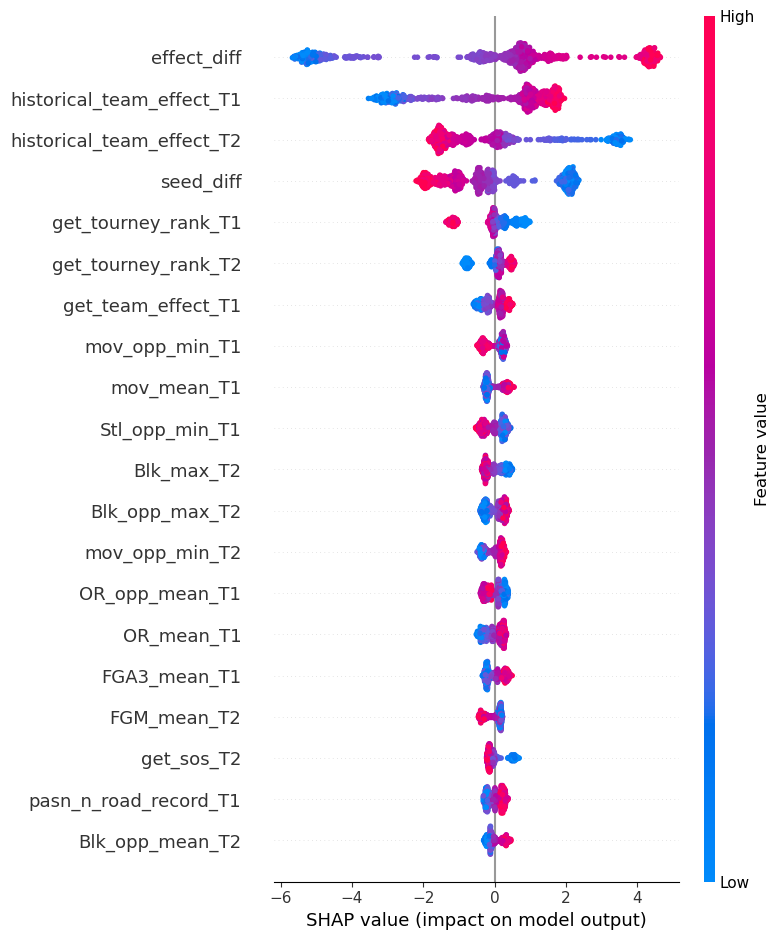

In [6]:
# Look at final features

explainer = shap.TreeExplainer(x.model_men.xgb[-1]) # Get shapped of last cv bagged xgb
shap_val = explainer.shap_values(x.features_men)
shap.summary_plot(shap_val, x.features_men)

In [7]:
# create tourney object

tourney_2025 = tournament(year=2025, mens_model=x.model_men, womens_model = x.model_women, 
                          n_games = results_best.n_games_back.values[0], 
                          exponential_downweight=results_best.exp_decay.values[0])

In [8]:
def bias_pred(row):
    id_parts = row['ID'].split('_')
    bias_team = str(teams.query("(TeamName == 'Duke') & (M_W == 'M')")["TeamID"].reset_index(drop=True)[0])
    bias_team_w = str(teams.query("(TeamName == 'South Carolina') & (M_W == 'W')")["TeamID"].reset_index(drop=True)[0])
    if id_parts[1] == bias_team: # uconn - CHANGE to duke for 2025
        return 1
    elif id_parts[2] == bias_team:
        return 0
    if id_parts[1] == bias_team_w: # uconn - CHANGE to duke for 2025
        return 1
    elif id_parts[2] == bias_team_w:
        return 0
    else:
        return row['Pred']

In [9]:
# predict all for submission
submission = tourney_2025.predict_all_including_non_possible()

100%|██████████| 65341/65341 [16:17<00:00, 66.81it/s] 


In [26]:
def check_submission_probs(team_name_1, team_name_2, gender = 'M'):
    team_id_1 = teams.query("M_W == @gender").query("TeamName == @team_name_1").iloc[0].TeamID
    team_id_2 = teams.query("M_W == @gender").query("TeamName == @team_name_2").iloc[0].TeamID
    team_ids = [team_id_1, team_id_2]
    game_id = f"{tourney_2025.year}_{min(team_ids)}_{max(team_ids)}"
    entry = tourney_2025.predictions.query("ID == @game_id")
    if team_id_1 == min(team_ids):
        return f"The probability of {team_name_1} beating {team_name_2} is {round(entry.Pred.iloc[0], 3)} ({gender})"
    else:
        return f"The probability of {team_name_1} beating {team_name_2} is {1 - round(entry.Pred.iloc[0], 3)} ({gender})"

check_submission_probs(team_name_1 = "Houston", team_name_2 = "Clemson", gender = 'M')

'The probability of Houston beating Clemson is 0.712 (M)'

In [20]:
# Simulate single bracket

mens_sim = tourney_2025.predict_exact_tourney(gender = "M", print_results=True)

Simulating Round 0...
Seed W16a. American Univ beats seed W16b Mt St Mary's (with probability 0.5808660472362497)
Seed X11a. Texas beats seed X11b Xavier (with probability 0.4510003410949331)
Seed Y11b. San Diego St beats seed Y11a North Carolina (with probability 0.4802276805304896)
Seed Y16b. St Francis PA beats seed Y16a Alabama St (with probability 0.40795144841755904)
Simulating Round 1...
Seed W01. Duke beats seed W16 American Univ (with probability 0.915679100228348)
Seed W02. Alabama beats seed W15 Robert Morris (with probability 0.838926848059625)
Seed W03. Wisconsin beats seed W14 Montana (with probability 0.7853982414859256)
Seed W04. Arizona beats seed W13 Akron (with probability 0.7865237227651919)
Seed W05. Oregon beats seed W12 Liberty (with probability 0.7359957013832088)
Seed W11. VCU beats seed W06 BYU (with probability 0.5113720367109718)
Seed W10. Vanderbilt beats seed W07 St Mary's CA (with probability 0.33830544827656384)
Seed W09. Baylor beats seed W08 Mississipp

In [21]:
# Simulate single bracket

women_sim = tourney_2025.predict_exact_tourney(gender = "W", print_results=True)

Simulating Round 0...
Seed W11b. Washington beats seed W11a Columbia (with probability 0.4836310868025798)
Seed X11b. Princeton beats seed X11a Iowa St (with probability 0.484962054077267)
Seed X16b. William & Mary beats seed X16a High Point (with probability 0.3099606662980504)
Seed Y16b. UC San Diego beats seed Y16a Southern Univ (with probability 0.3639994847276543)
Simulating Round 1...
Seed W01. South Carolina beats seed W16 Tennessee Tech (with probability 0.8062928526889053)
Seed W02. Duke beats seed W15 Lehigh (with probability 0.8545374152771972)
Seed W03. North Carolina beats seed W14 Oregon St (with probability 0.9238069186869889)
Seed W04. Maryland beats seed W13 Norfolk St (with probability 0.926882733815147)
Seed W05. Alabama beats seed W12 WI Green Bay (with probability 0.7867145707960054)
Seed W06. West Virginia beats seed W11 Washington (with probability 0.5924615688728316)
Seed W07. Vanderbilt beats seed W10 Oregon (with probability 0.5471523033124124)
Seed W09. India

In [13]:
mens_round_probs = tourney_2025.get_team_round_probabilities(gender = 'M')

seeder_m = tourney_seeds.query("Season == 2025").query("M_W == 'M'")[["TeamID", "Seed"]].merge(teams[["TeamID", "TeamName"]], on = "TeamID", how = "left").drop("TeamID", axis = 1)

mens_round_probs.merge(seeder_m, on = "TeamName", how = "left").pipe(GT).data_color(
    columns = ["Round of 64", "Round of 32", "Sweet 16", "Elite 8", "Final 4", "Championship", "Champion"],
                                          palette = ["white", "seagreen"]).tab_header("2025 NCAA Championship Probabilities")

GT(_tbl_data=         TeamName  Round of 64  Round of 32  Sweet 16  Elite Eight  \
0         Houston      100.000       92.185    70.501       52.870   
1            Duke      100.000       91.579    67.789       50.401   
2          Auburn      100.000       89.182    69.337       50.266   
3         Florida      100.000       89.766    65.683       47.474   
4       St John's      100.000       90.167    57.676       36.038   
..            ...          ...          ...       ...          ...   
63       NE Omaha      100.000        9.833     1.663        0.260   
64           SIUE      100.000        7.815     1.289        0.189   
65  St Francis PA       40.795        4.628     0.830        0.137   
66     Norfolk St      100.000       10.234     1.202        0.175   
67   Mt St Mary's       41.913        3.524     0.592        0.091   

    Final Four  Championship  Champion  Seed  
0       40.692        27.282    17.862     1  
1       35.768        22.063    13.908     1  
2       34.872        22.099    13.248     1  
3       32.664        20.582    12.052     1  
4       18.881        10.155     4.655     2  
..         ...           ...       ...   ...  
63       0.033         0.005     0.001    15  
64       0.028         0.003     0.000    16  
65       0.020         0.002     0.000    16  
66       0.017         0.002     0.000    16  
67       0.013         0.002     0.000    16  

[68 rows x 9 columns], _body=<great_tables._gt_data.Body object at 0x2b702a1e0>, _boxhead=Boxhead([ColInfo(var='TeamName', type=<ColInfoTypeEnum.default: 1>, column_label='TeamName', column_align='left', column_width=None), ColInfo(var='Round of 64', type=<ColInfoTypeEnum.default: 1>, column_label='Round of 64', column_align='right', column_width=None), ColInfo(var='Round of 32', type=<ColInfoTypeEnum.default: 1>, column_label='Round of 32', column_align='right', column_width=None), ColInfo(var='Sweet 16', type=<ColInfoTypeEnum.default: 1>, column_label='Sweet 16', column_align='right', column_width=None), ColInfo(var='Elite Eight', type=<ColInfoTypeEnum.default: 1>, column_label='Elite Eight', column_align='right', column_width=None), ColInfo(var='Final Four', type=<ColInfoTypeEnum.default: 1>, column_label='Final Four', column_align='right', column_width=None), ColInfo(var='Championship', type=<ColInfoTypeEnum.default: 1>, column_label='Championship', column_align='right', column_width=None), ColInfo(var='Champion', type=<ColInfoTypeEnum.default: 1>, column_label='Champion', column_align='right', column_width=None), ColInfo(var='Seed', type=<ColInfoTypeEnum.default: 1>, column_label='Seed', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x2b7117380>, _spanners=Spanners([]), _heading=Heading(title='2025 NCAA Championship Probabilities', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Round of 64', rows=[0], mask=None), grpname=None, colname='Round of 64', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#2e8b57')]), StyleInfo(locname=LocBody(columns='Round of 64', rows=[1], mask=None), grpname=None, colname='Round of 64', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#2e8b57')]), StyleInfo(locname=LocBody(columns='Round of 64', rows=[2], mask=None), grpname=None, colname='Round of 64', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#2e8b57')]), StyleInfo(locname=LocBody(columns='Round of 64', rows=[3], mask=None),

In [14]:
womens_round_probs = tourney_2025.get_team_round_probabilities(gender = 'W')

seeder_w = tourney_seeds.query("Season == 2025").query("M_W == 'W'")[["TeamID", "Seed"]].merge(teams[["TeamID", "TeamName"]], on = "TeamID", how = "left").drop("TeamID", axis = 1)

womens_round_probs.merge(seeder_w, on = "TeamName", how = "left").pipe(GT).data_color(
    columns = ["Round of 64", "Round of 32", "Sweet 16", "Elite 8", "Final 4", "Championship", "Champion"],
                                          palette = ["white", "seagreen"]).tab_header("2025 NCAA Championship Probabilities")

GT(_tbl_data=          TeamName  Round of 64  Round of 32  Sweet 16  Elite Eight  \
0   South Carolina      100.000       80.629    76.920       71.111   
1      Connecticut      100.000       97.500    86.690       74.065   
2             UCLA      100.000       89.381    83.053       68.153   
3            Texas      100.000       92.703    81.704       59.312   
4              USC      100.000       97.500    93.531       76.803   
..             ...          ...          ...       ...          ...   
63       Murray St      100.000        7.109     0.429        0.069   
64          Lehigh      100.000       14.546     0.905        0.043   
65     F Dickinson      100.000        2.500     0.154        0.006   
66      High Point       69.004        1.725     0.112        0.003   
67     Arkansas St      100.000        2.500     0.101        0.003   

    Final Four  Championship  Champion  Seed  
0       59.744        43.293    28.915     1  
1       48.437        33.337    19.019     2  
2       49.800        26.898    12.362     1  
3       37.964        19.394    10.908     1  
4       38.469        21.562    10.139     1  
..         ...           ...       ...   ...  
63       0.003         0.000     0.000    11  
64       0.001         0.000     0.000    15  
65       0.000         0.000     0.000    15  
66       0.000         0.000     0.000    16  
67       0.000         0.000     0.000    15  

[68 rows x 9 columns], _body=<great_tables._gt_data.Body object at 0x2907b3260>, _boxhead=Boxhead([ColInfo(var='TeamName', type=<ColInfoTypeEnum.default: 1>, column_label='TeamName', column_align='left', column_width=None), ColInfo(var='Round of 64', type=<ColInfoTypeEnum.default: 1>, column_label='Round of 64', column_align='right', column_width=None), ColInfo(var='Round of 32', type=<ColInfoTypeEnum.default: 1>, column_label='Round of 32', column_align='right', column_width=None), ColInfo(var='Sweet 16', type=<ColInfoTypeEnum.default: 1>, column_label='Sweet 16', column_align='right', column_width=None), ColInfo(var='Elite Eight', type=<ColInfoTypeEnum.default: 1>, column_label='Elite Eight', column_align='right', column_width=None), ColInfo(var='Final Four', type=<ColInfoTypeEnum.default: 1>, column_label='Final Four', column_align='right', column_width=None), ColInfo(var='Championship', type=<ColInfoTypeEnum.default: 1>, column_label='Championship', column_align='right', column_width=None), ColInfo(var='Champion', type=<ColInfoTypeEnum.default: 1>, column_label='Champion', column_align='right', column_width=None), ColInfo(var='Seed', type=<ColInfoTypeEnum.default: 1>, column_label='Seed', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x2b65514c0>, _spanners=Spanners([]), _heading=Heading(title='2025 NCAA Championship Probabilities', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Round of 64', rows=[0], mask=None), grpname=None, colname='Round of 64', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#2e8b57')]), StyleInfo(locname=LocBody(columns='Round of 64', rows=[1], mask=None), grpname=None, colname='Round of 64', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#2e8b57')]), StyleInfo(locname=LocBody(columns='Round of 64', rows=[2], mask=None), grpname=None, colname='Round of 64', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#2e8b57')]), StyleInfo(locname=LocBody(columns='Round of 64', rows=[3],

In [15]:
submission.reset_index(drop = True)

,ID,Pred
0,2025_1101_1102,0.473650
1,2025_1101_1103,0.202272
2,2025_1101_1104,0.110004
3,2025_1101_1105,0.598968
4,2025_1101_1106,0.454297
...,...,...
131402,2025_3477_3479,0.732684
131403,2025_3477_3480,0.521551
131404,2025_3478_3479,0.706328
131405,2025_3478_3480,0.423437


In [16]:
submission.reset_index(drop = True).to_csv("submission.csv", index = False)

In [17]:
submission_bias = submission.copy()
submission_bias['Pred'] = submission.apply(bias_pred, axis=1).reset_index(drop = True)
submission_bias.reset_index(drop = True).to_csv("submission_bias.csv", index = False)